## 练习

1. 继续提高`finetune_net`的学习率，模型的准确性如何变化？
2. 在比较实验中进一步调整`finetune_net`和`scratch_net`的超参数。它们的准确性还有不同吗？
3. 将输出层`finetune_net`之前的参数设置为源模型的参数，在训练期间不要更新它们。模型的准确性如何变化？提示：可以使用以下代码。

loss 1.207, train acc 0.577, test acc 0.579
292.0 examples/sec on [device(type='cuda', index=0)]


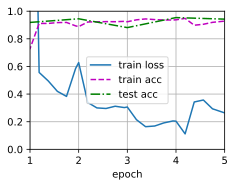

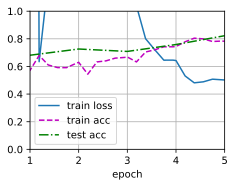

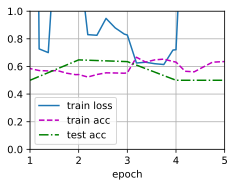

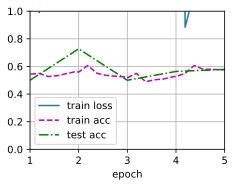

In [1]:
import os
import torch
from torch import nn
import torchvision
from d2l import torch as d2l

# 数据下载和加载
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

# 图像增广
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

# 模型定义
pretrained_net = torchvision.models.resnet18(pretrained=True)
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

# 微调函数
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# 训练模型，逐步提高学习率
for lr in [0.0001, 0.0005, 0.001, 0.005]:
    print(f"Training finetune_net with learning rate: {lr}")
    train_fine_tuning(finetune_net, lr)

loss 0.357, train acc 0.849, test acc 0.854
290.2 examples/sec on [device(type='cuda', index=0)]
Training scratch_net with lr=0.001, wd=0.001, optimizer=SGD


NameError: name 'scratch_net' is not defined

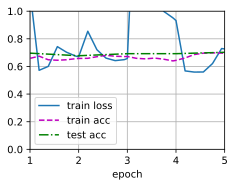

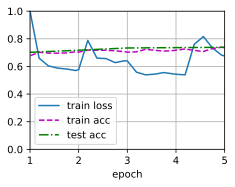

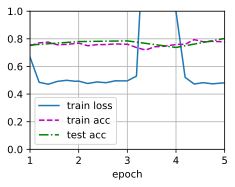

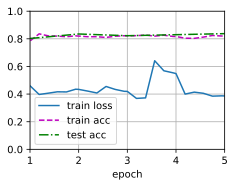

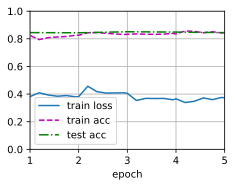

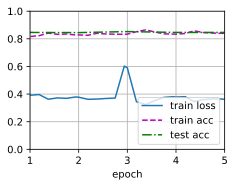

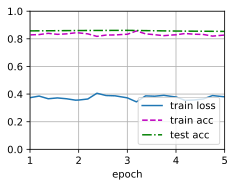

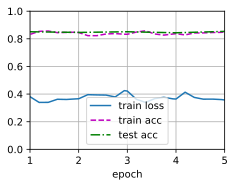

In [2]:
# 函数：训练模型
def train_model(net, train_iter, test_iter, num_epochs, lr, wd, optimizer):
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = optimizer(net.parameters(), lr=lr, weight_decay=wd)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# 实验设置
batch_size = 128
train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size=batch_size)

# 超参数组合
lr_options = [0.001, 0.0005]
wd_options = [0.001, 0.0001]
optimizer_options = [torch.optim.SGD, torch.optim.Adam]

# 对finetune_net进行实验
for lr in lr_options:
    for wd in wd_options:
        for optimizer in optimizer_options:
            print(f"Training finetune_net with lr={lr}, wd={wd}, optimizer={optimizer.__name__}")
            train_model(finetune_net, train_iter, test_iter, 5, lr, wd, optimizer)

# 对scratch_net进行实验
for lr in lr_options:
    for wd in wd_options:
        for optimizer in optimizer_options:
            print(f"Training scratch_net with lr={lr}, wd={wd}, optimizer={optimizer.__name__}")
            train_model(scratch_net, train_iter, test_iter, 5, lr, wd, optimizer)

loss 0.307, train acc 0.869, test acc 0.874
419.9 examples/sec on [device(type='cuda', index=0)]


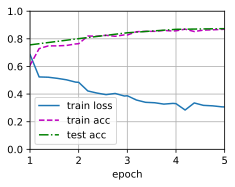

In [3]:
# 加载预训练的模型
finetune_net = torchvision.models.resnet18(pretrained=True)

# 冻结除输出层之外的所有层
for param in finetune_net.parameters():
    param.requires_grad = False

# 重新初始化输出层
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

# 训练微调模型
train_model(finetune_net, train_iter, test_iter, num_epochs=5, lr=0.001, wd=0.001, optimizer=torch.optim.Adam)